In [1]:
import os
import random
import string
import re
import requests
import gzip
import shutil
import json
import types
import datetime
import decimal
import pandas as pd
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
import pylab as py
import scipy.stats as stats
import seaborn as sns
from IPython.display import display, HTML

if not os.path.exists('artefacts'):
    os.makedirs('artefacts')

In [2]:

endpoint = "http://149.148.106.184:9999/blazegraph/sparql"  # SPARQL endpoint hosting previous version of ITO.owl
prefixes = """
prefix owl: <http://www.w3.org/2002/07/owl#>
prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
prefix xsd: <http://www.w3.org/2001/XMLSchema#>
prefix ito: <https://identifiers.org/ito:>
prefix edam: <http://edamontology.org/>
prefix obo: <http://www.geneontology.org/formats/oboInOwl#>
prefix dc: <http://purl.org/dc/elements/1.1/>
"""


def query(query, return_format = JSON):
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(return_format)
    sparql.setQuery(prefixes + query)
    results = sparql.query().convert()
    return results


def query_df(query, numeric_cols = []):
    # Run SPARQL query, and convert results to Pandas dataframe
    sparql = SPARQLWrapper(endpoint)
    sparql.method = 'POST'
    sparql.setReturnFormat(JSON)
    sparql.setQuery(prefixes + query)
    results = sparql.query()
    processed_results = json.load(results.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df

def tasks_stat_dict(df):
    from collections import defaultdict
    tasks_stat = defaultdict(int)
    for idx, row in df.iterrows():
        for task in row["tasks"]:
            tasks_stat[task] += 1
    return dict(sorted(tasks_stat.items(), key=lambda x: x[1], reverse=True))
    

In [3]:
filename = './datasets.json.gz'
if not os.path.exists(filename):
    url = 'https://paperswithcode.com/media/about/datasets.json.gz'
    myfile = requests.get(url)
    with open(filename, 'wb') as o:
        o.write(myfile.content)
    with gzip.open(filename, 'rb') as f_in:
        with open('./datasets.json', 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

with open('datasets.json') as f:
    datasets_ = json.load(f)
    
variant_to_parent = list()
variant_to_url = dict()
# unprioritize independency

for dataset in datasets_:
    variant_to_url[dataset["name"]] = dataset["url"]
for dataset in datasets_:
    ## create variant_to_parent mapping 
    for variant in dataset["variants"]:
        if dataset["name"] != variant:
            variant_to_parent.append([variant, dataset["name"]])
            variant_to_url[dataset["name"]] = dataset["url"]
variant_to_parent = pd.DataFrame(variant_to_parent, columns=["variant", "parent"])
variant_to_parent

,variant,parent
0,USPS-to-MNIST,MNIST
1,MNIST-to-USPS,MNIST
2,Rotating MNIST,MNIST
3,Noisy MNIST (Motion),MNIST
4,Noisy MNIST (Contrast),MNIST
...,...,...
1977,Detection-Only (Test Set),Argoverse-HD
1978,FREDo (cross-domain),FREDo
1979,Derczynski,IPM NEL
1980,domenicrosati/QA2D,QA2D


In [4]:
var = "n_unique_paper_sum"
label_x = "Number of papers utilizing dataset"
label_y = "Number of datasets"
first_year = 2018
min_n_entries = 0
prefix="cv"
root = "https://identifiers.org/ito:ITO_00101"

In [5]:
df = query_df("""
SELECT * WHERE {
    ?benchmark rdfs:subClassOf+ <""" + root + """> .
    ?benchmark rdfs:subClassOf <https://identifiers.org/ito:Benchmarking> .
    ?benchmark rdfs:label ?benchmark_label .
    ?result rdf:type ?benchmark .
    ?result ito:has_input ?dataset .
    OPTIONAL{
        ?result obo:date ?date .
        ?result rdfs:seeAlso ?paper .
        ?paper a edam:data_0971 .
        ?paper rdfs:label ?paper_label .
    }
}
""")
df["benchmark_label"] = df["benchmark_label"].str.replace(" benchmarking", "")
df[["benchmark_label", "task_label"]] = df["benchmark_label"].str.split(' - ', 1, expand=True)
df["date"] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.sort_values(by="date")

# df["benchmark_parent_label"] = df["benchmark_label"].apply(lambda x: variant_to_parent.get(x, None))

df = df.merge(variant_to_parent, left_on="benchmark_label", right_on="variant", how="left")
df = df.rename(columns={"parent": "benchmark_parent_label"}).drop(columns="variant")
df["benchmark_parent_label"] = df["benchmark_parent_label"].fillna(df["benchmark_label"])
df = df.dropna(subset=["benchmark_parent_label"])

def agg(examples):
    examples = examples.sort_values(by="date")
    first_date = examples.iloc[0]["date"]
    tasks = set(examples["task_label"])
    count = examples.groupby(["benchmark_label"])["benchmark_label"].count()
    
    papers = examples[["benchmark_label", "paper_label"]]
    papers = papers.dropna().drop_duplicates()
    count_paper = papers.groupby(["benchmark_label"])["paper_label"].count()
    return pd.Series({
        "first_date": first_date, 
        "n_variant": len(set(examples["benchmark_label"])), 
        "n_row_sum": count.sum(), 
        "n_row_min": count.min(), 
        "n_row_max": count.max(), 
        "n_row_mean": count.mean(), 
        "n_unique_paper_sum": len(set(papers["paper_label"])), 
        "n_paper_min": count_paper.min(), 
        "n_paper_max": count_paper.max(), 
        "n_paper_mean": count_paper.mean(), 
        "n_tasks": len(tasks), 
        "tasks": tasks})

df = df.groupby(["benchmark_parent_label"])[["benchmark_parent_label", "result", "date", "benchmark_label", "paper_label", "task_label"]].apply(agg).reset_index()
df["url"] = df["benchmark_parent_label"].apply(lambda x: variant_to_url.get(x, None))
df = df.sort_values(by=var, ascending=False)
df = df[df[var] > 0]
df.to_csv(f"artefacts/{prefix}_all_unfiltered.csv", index=None)

In [6]:
def split_popular_unpopular(df):
    cumsum = df.sort_values(by=[var]).reset_index(drop=True)
    cumsum["cumsum"] = cumsum[var].cumsum()
    max_ = cumsum["cumsum"].max()
    half = max_ / 2.

    foo = 0
    for ix, row in cumsum.iterrows():
        if row["cumsum"] > half:
            corr_ix = ix
            break

    print(f"{corr_ix * 100 / len(cumsum)} % of smallest datasets have the same amount of papers as {100 - (corr_ix * 100 / len(cumsum))} % of biggest datasets")
    print(f"Length popular: {len(cumsum) - corr_ix}")
    popular = cumsum.iloc[corr_ix:].sort_values(by=var, ascending=False)
    unpopular = cumsum.iloc[:corr_ix].sample(len(popular), random_state=1).sort_values(by=var, ascending=False)
    
    popular_task_types = pd.DataFrame(tasks_stat_dict(popular).items(), columns=["task_type", "n"])
    unpopular_task_types = pd.DataFrame(tasks_stat_dict(unpopular).items(), columns=["task_type", "n"])
    
    return popular, unpopular, popular_task_types, unpopular_task_types

## Plots for all datasets

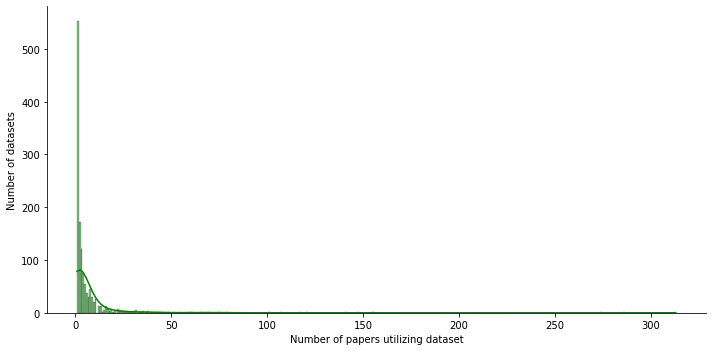

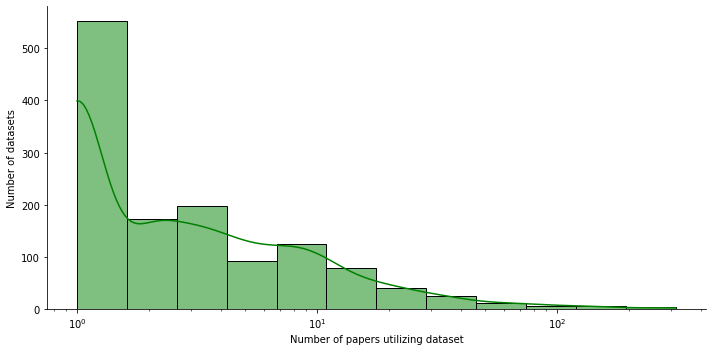

,n_variant,n_row_sum,n_row_min,n_row_max,n_row_mean,n_unique_paper_sum,n_paper_min,n_paper_max,n_paper_mean,n_tasks
count,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000,1307.000000
mean,1.406274,11.075746,4.690895,8.346595,5.683755,6.736037,3.684009,5.830145,4.284033,1.495792
std,1.984100,41.139619,8.306030,27.168015,9.887644,19.274354,5.681200,14.543021,6.220933,1.780171
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,3.000000,2.000000,3.000000,2.333333,2.000000,2.000000,2.000000,2.000000,1.000000
75%,1.000000,8.000000,5.000000,7.000000,6.500000,6.000000,4.000000,5.000000,5.000000,1.000000
max,41.000000,808.000000,121.000000,619.000000,134.000000,313.000000,79.000000,242.000000,79.000000,31.000000


94.10864575363428 % of smallest datasets have the same amount of papers as 5.891354246365722 % of biggest datasets
Length popular: 77


,n_tasks,n_variant
count,77.000000,77.000000
mean,5.428571,4.844156
std,5.499829,6.160282
min,1.000000,1.000000
25%,2.000000,1.000000
50%,4.000000,3.000000
75%,6.000000,5.000000
max,31.000000,41.000000


,n_tasks,n_variant
count,77.000000,77.000000
mean,1.389610,1.220779
std,0.860781,0.940652
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,5.000000,7.000000


,benchmark_parent_label,n_unique_paper_sum,n_variant,n_tasks,tasks,url
1306,ImageNet,313,18,25,"{'10-shot - Few-Shot Image Classification', 'Image Recognition', 'Zero-Shot Object Detection', 'Weakly Supervised Object Detection', 'Weakly-Supervised Object Localization', '1-shot - Few-Shot Image Classification', 'Classification Consistency', '5-shot - Few-Shot Image Classification', 'Long-tail Learning', '10% labeled data - Semi-Supervised Image Classification', 'Image Classification', 'Domain Generalization', 'Unsupervised Domain Adaptation', 'Image Compression', 'Partial Domain Adaptation', 'Image Generation', 'Quantization', 'Color Image Denoising', '10% labeled data - Image Generation', 'Image Clustering', 'Conditional Image Generation', 'Self-Supervised Image Classification', '1% labeled data - Semi-Supervised Image Classification', '0-Shot - Few-Shot Image Classification', 'Unsupervised Image Classification'}",https://paperswithcode.com/dataset/imagenet
1305,COCO,286,26,31,"{'Instance Segmentation', 'Object Detection', 'Zero-Shot Object Detection', 'Text-Image Retrieval', 'Weakly Supervised Object Detection', 'Zero-Shot Text-to-Image Generation', 'Activeness Detection', 'Panoptic Segmentation', 'Real-Time Object Detection', 'One-Shot Instance Segmentation', 'Active Object Detection', 'Pose Estimation', 'Visual Question Answering', 'Open World Object Detection', 'Image Captioning', 'Layout-to-Image Generation', 'Multi-Person Pose Estimation', 'Object Counting', 'Few-Shot Object Detection', 'Robust Object Detection', 'Conditional Image Generation', 'Text-to-Image Generation', 'Interactive Segmentation', 'Real-time Instance Segmentation', 'Single-object discovery', 'One-Shot Object Detection', 'Homography Estimation', 'Unsupervised Semantic Segmentation', 'Keypoint Detection', 'Multi-object discovery', 'Cross-Modal Retrieval'}",https://paperswithcode.com/dataset/coco
1304,CIFAR-10,274,16,11,"{'Quantization', 'Semi-Supervised Image Classification', 'Long-tail Learning', 'Image Classification', 'Image Clustering', 'Small Data Image Classification', 'Image Compression', 'Conditional Image Generation', 'Unsupervised Image Classification', 'Out-of-Distribution Detection', 'Image Generation'}",https://paperswithcode.com/dataset/cifar-10
1303,PASCAL VOC,156,14,18,"{'Object Counting', 'Object Detection', 'Weakly Supervised Object Detection', 'Single-object discovery', 'Weakly-supervised instance segmentation', 'Real-Time Object Detection', 'One-Shot Object Detection', 'Weakly-Supervised Semantic Segmentation', 'Object Localization', 'Semantic Segmentation', 'Object Proposal Generation', 'Unsupervised Semantic Segmentation', 'Multi-object colocalization', 'Open World Object Detection', 'Image Classification', 'Robust Object Detection', 'Multi-object discovery', 'Semi-Supervised Semantic Segmentation'}",https://paperswithcode.com/dataset/pascal-voc
1302,Cityscapes,155,11,13,"{'Instance Segmentation', 'Scene Parsing', 'Interactive Segmentation', 'Panoptic Segmentation', 'Real-Time Semantic Segmentation', 'Image Generation', 'Semantic Segmentation', 'Image-to-Image Translation', 'Depth Estimation', 'Edge Detection', 'Robust Object Detection', 'Video Semantic Segmentation', 'Semi-Supervised Semantic Segmentation'}",https://paperswithcode.com/dataset/cityscapes
1301,KITTI,147,41,26,"{'Object Detection', 'Depth Completion', 'Visual Place Recognition', 'Vehicle Pose Estimation', 'Horizon Line Estimation', 'Panoptic Segmentation', 'Multiple Object Tracking', 'Novel View Synthesis', '3D Object Detection', 'Unsupervised Domain Adaptation', '3D Multi-Object Tracking', 'Face Verification', '2x upscaling - Image Super-Resolution', 'Monocular 3D Object Detection', 'Stereo Depth Estimation', 'Monocular Depth Estimation', 'Dense Pixel Correspondence Estimation', 'Birds Eye View Object Detection', 'Optical Flow Estimation', 'Point Cloud Registration', 'Object Localization', 'Semantic Segmentation', 'Image-to-Image Translation', '4x upscaling - Image S

,benchmark_parent_label,n_unique_paper_sum,n_variant,n_tasks,tasks,url
1197,AVA,16,3,2,"{'Action Recognition', 'Audio-Visual Active Speaker Detection'}",https://paperswithcode.com/dataset/ava
1194,DeepFashion,15,2,5,"{'Virtual Try-on', 'Image Retrieval', 'Pose Transfer', 'Consumer-to-shop - Image Retrieval', 'Image-to-Image Translation'}",https://paperswithcode.com/dataset/deepfashion
1186,Kuzushiji-MNIST,13,1,2,"{'Image Classification', 'Fine-Grained Image Classification'}",https://paperswithcode.com/dataset/kuzushiji-mnist
1182,Semantic3D,13,1,1,{'Semantic Segmentation'},https://paperswithcode.com/dataset/semantic3d
1178,ImageCLEF-DA,13,1,1,{'Domain Adaptation'},https://paperswithcode.com/dataset/imageclef-da
1168,UAV-Human,12,1,4,"{'Pedestrian Attribute Recognition', 'Person Re-Identification', 'Skeleton Based Action Recognition', 'Pose Estimation'}",https://paperswithcode.com/dataset/uav-human
1134,SHREC,10,6,4,"{'Hand Gesture Recognition', '3D Object Recognition', 'Point Cloud Super Resolution', 'Skeleton Based Action Recognition'}",https://paperswithcode.com/dataset/shrec
1132,LIVE1,10,7,1,{'JPEG Artifact Correction'},https://paperswithcode.com/dataset/live1
1103,PASCAL-Part,9,1,2,"{'Human Part Segmentation', 'Multi-Human Parsing'}",https://paperswithcode.com/dataset/pascal-person-part
1075,N-UCLA,8,1,1,{'Skeleton Based Action Recognition'},None


,task_type,n
0,Image Classification,16
1,Image Generation,13
2,Semantic Segmentation,12
3,Image Clustering,9
4,Image-to-Image Translation,7
5,4x upscaling - Image Super-Resolution,7
6,Few-Shot Image Classification,7
7,Fine-Grained Image Classification,7
8,Domain Adaptation,7
9,Action Recognition,7


,task_type,n
0,Continuous Control,5
1,Skeleton Based Action Recognition,4
2,Image Generation,4
3,Image-to-Image Translation,3
4,Trajectory Prediction,3
5,Virtual Try-on,2
6,Image Retrieval,2
7,Image Classification,2
8,Face Alignment,2
9,Emotion Recognition in Conversation,2


In [7]:
g = sns.displot(df[var], color='g', kind="hist", kde=True, aspect=2)
g.set_axis_labels(label_x, label_y)
plt.savefig(f"artefacts/{prefix}.png")
plt.show()

g = sns.displot(df[var], color='g', kind="hist", kde=True, aspect=2, log_scale=True, bins=12)
g.set_axis_labels(label_x, label_y)
plt.savefig(f"artefacts/{prefix}_log.png")
plt.show()

display(df.describe())

popular, unpopular, popular_task_types, unpopular_task_types = split_popular_unpopular(df)

display(popular[["n_tasks", "n_variant"]].describe())
display(unpopular[["n_tasks", "n_variant"]].describe())

display(popular[["benchmark_parent_label", var, "n_variant", "n_tasks", "tasks", "url"]].style.set_caption("Popular benchmarks"))
popular.to_csv(f"artefacts/{prefix}_popular.csv", index=None)

display(unpopular[["benchmark_parent_label", var, "n_variant", "n_tasks", "tasks", "url"]].style.set_caption("Unpopular benchmarks"))
unpopular.to_csv(f"artefacts/{prefix}_unpopular.csv", index=None)

display(popular_task_types.style.set_caption("Task types in popular"))
popular_task_types.to_csv(f"artefacts/{prefix}_popular_task_types.csv", index=None)

display(unpopular_task_types.style.set_caption("Task types in unpopular"))
unpopular_task_types.to_csv(f"artefacts/{prefix}_unpopular_task_types.csv", index=None)

## Plots for datasets created in 2018

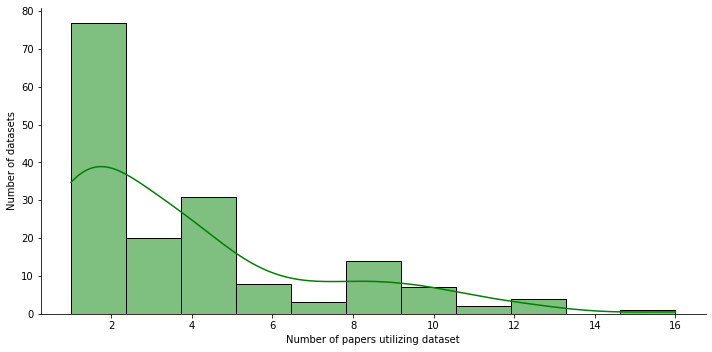

,n_variant,n_row_sum,n_row_min,n_row_max,n_row_mean,n_unique_paper_sum,n_paper_min,n_paper_max,n_paper_mean,n_tasks
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,1.185629,5.161677,4.257485,4.532934,4.402196,3.832335,3.467066,3.706587,3.594810,1.305389
std,0.673265,5.720727,4.248266,4.255095,4.219990,3.167327,3.108063,3.101324,3.069121,0.691711
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.000000,3.000000,2.500000,1.000000
75%,1.000000,6.000000,6.000000,6.000000,6.000000,5.000000,4.000000,5.000000,4.000000,1.000000
max,6.000000,47.000000,30.000000,30.000000,30.000000,16.000000,16.000000,16.000000,16.000000,5.000000


78.44311377245509 % of smallest datasets have the same amount of papers as 21.556886227544908 % of biggest datasets
Length popular: 36


,n_tasks,n_variant
count,36.000000,36.000000
mean,1.611111,1.472222
std,1.076443,1.230241
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,5.000000,6.000000


,n_tasks,n_variant
count,36.000000,36.000000
mean,1.083333,1.055556
std,0.368394,0.232311
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,3.000000,2.000000


,benchmark_parent_label,n_unique_paper_sum,n_variant,n_tasks,tasks,url
166,Oxford-IIIT Pets,16,1,3,"{'Fine-Grained Image Classification', 'Image Compression', 'Image Classification'}",https://paperswithcode.com/dataset/oxford-iiit-pets
165,ETH,13,1,1,{'Trajectory Prediction'},https://paperswithcode.com/dataset/eth
164,Mini-ImageNet,12,1,1,{'1-Shot Learning - Few-Shot Image Classification'},None
163,PASCAL-5i (1-Shot),12,1,1,{'Few-Shot Semantic Segmentation'},None
162,PASCAL-5i (5-Shot),12,1,1,{'Few-Shot Semantic Segmentation'},None
161,Mapillary Vistas Dataset,11,1,3,"{'Semantic Segmentation', 'Visual Place Recognition', 'Panoptic Segmentation'}",https://paperswithcode.com/dataset/mapillary-vistas-dataset
160,SIDD,11,1,1,{'Image Denoising'},https://paperswithcode.com/dataset/sidd
156,DND,10,1,1,{'Image Denoising'},https://paperswithcode.com/dataset/dnd
153,FC100,10,3,1,{'Few-Shot Image Classification'},https://paperswithcode.com/dataset/fc100
154,In-Shop,10,1,2,"{'Metric Learning', 'Image Retrieval'}",None


,benchmark_parent_label,n_unique_paper_sum,n_variant,n_tasks,tasks,url
128,GOT-10k,6,1,1,{'Visual Object Tracking'},https://paperswithcode.com/dataset/got-10k
121,COCO 2014 val,5,1,1,{'Weakly-Supervised Semantic Segmentation'},None
126,UCF-Crime,5,1,1,{'Anomaly Detection In Surveillance Videos'},https://paperswithcode.com/dataset/ucf-crime
111,Sequential CIFAR-10,4,1,1,{'Sequential Image Classification'},None
116,DocUNet,4,1,1,{'MS-SSIM'},None
102,PanoContext,4,1,1,{'3D Room Layouts From A Single RGB Panorama'},https://paperswithcode.com/dataset/panocontext
110,BraTS 2018,4,2,1,{'Brain Tumor Segmentation'},https://paperswithcode.com/dataset/brats-2018-1
97,ISIC 2018,4,1,1,{'Lesion Segmentation'},None
118,O-HAZE,4,1,1,{'Image Dehazing'},https://paperswithcode.com/dataset/o-haze-1
114,VeRi-776,4,1,1,{'Vehicle Re-Identification'},https://paperswithcode.com/dataset/veri-776


,task_type,n
0,Fine-Grained Image Classification,2
1,Few-Shot Semantic Segmentation,2
2,Semantic Segmentation,2
3,Image Denoising,2
4,Skeleton Based Action Recognition,2
5,Self-Supervised Action Recognition,2
6,Unsupervised Domain Adaptation,2
7,Lipreading,2
8,Semantic correspondence,2
9,Object Detection,2


,task_type,n
0,Action Recognition,2
1,Traffic Sign Recognition,2
2,Visual Question Answering,2
3,Visual Object Tracking,1
4,Weakly-Supervised Semantic Segmentation,1
5,Anomaly Detection In Surveillance Videos,1
6,Sequential Image Classification,1
7,MS-SSIM,1
8,3D Room Layouts From A Single RGB Panorama,1
9,Brain Tumor Segmentation,1


In [8]:
# filter year
if first_year > -1:
    filtered_df = df[df['first_date'].dt.year == first_year]


g = sns.displot(filtered_df[var], color='g', kind="hist", kde=True, aspect=2)
g.set_axis_labels(label_x, label_y)
plt.savefig(f"artefacts/{prefix}_2018.png")
plt.show()

display(filtered_df.describe())

popular, unpopular, popular_task_types, unpopular_task_types = split_popular_unpopular(filtered_df)

display(popular[["n_tasks", "n_variant"]].describe())
display(unpopular[["n_tasks", "n_variant"]].describe())

display(popular[["benchmark_parent_label", var, "n_variant", "n_tasks", "tasks", "url"]].style.set_caption("Popular benchmarks"))
popular.to_csv(f"artefacts/{prefix}_popular_2018.csv", index=None)

display(unpopular[["benchmark_parent_label", var, "n_variant", "n_tasks", "tasks", "url"]].style.set_caption("Unpopular benchmarks"))
unpopular.to_csv(f"artefacts/{prefix}_unpopular_2018.csv", index=None)

display(popular_task_types.style.set_caption("Task types in popular"))
popular_task_types.to_csv(f"artefacts/{prefix}_popular_task_types_2018.csv", index=None)

display(unpopular_task_types.style.set_caption("Task types in unpopular"))
unpopular_task_types.to_csv(f"artefacts/{prefix}_unpopular_task_types_2018.csv", index=None)